<a href="https://colab.research.google.com/github/ElektrosStulpas/MusicGenerationGMM22/blob/aurimas/DDSPresynth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.
print('Installing from pip package...')
!pip install -qU ddsp==1.6.5

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab.colab_utils import (
    auto_tune, get_tuning_factor, download, 
    play, record, specplot, upload, 
    DEFAULT_SAMPLE_RATE, audio_bytes_to_np)
from ddsp.training.postprocessing import (
    detect_notes, fit_quantile_transform
)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import pandas as pd

# Helper Functions
sample_rate = DEFAULT_SAMPLE_RATE  # 16000

Installing from pip package...



Extracting audio features...


Audio features took 83.2 seconds


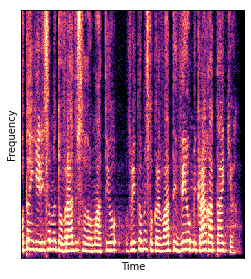

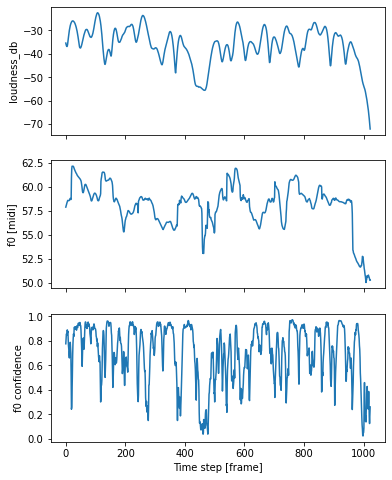

In [51]:
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 

def read_wav_to_array(filename):
  with open(filename, "rb") as f:
    data = f.read()
  audio = audio_bytes_to_np(data, normalize_db=None)
  if len(audio.shape) == 1:
    audio = audio[np.newaxis, :]
  return audio

audio = read_wav_to_array("s01 (1).wav")

if len(audio.shape) == 1:
  audio = audio[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio)
play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
def get_audio_features(audio):
  audio_features = ddsp.training.metrics.compute_audio_features(audio)
  audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
  audio_features_mod = None
  return audio_features, audio_features_mod

audio_features, audio_features_mod = get_audio_features(audio)
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')

MODEL PREP

In [52]:
#@title Load a model
#@markdown Run for ever new audio input
model = 'Flute' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone', 'Upload your own (checkpoint folder as .zip)']
MODEL = model


def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir 

if model in ('Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone'):
  # Pretrained models.
  PRETRAINED_DIR = '/content/drive/MyDrive/GMMGroup/pretrained'
  # Copy over from gs:// for faster loading.
  !rm -r $PRETRAINED_DIR &> /dev/null
  !mkdir $PRETRAINED_DIR &> /dev/null
  GCS_CKPT_DIR = 'gs://ddsp/models/timbre_transfer_colab/2021-07-08'
  model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())
  
  !gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
  model_dir = PRETRAINED_DIR
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')


# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths
def trim_input(audio_features, time_steps, n_samples):
  for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
    audio_features[key] = audio_features[key][:time_steps]
  audio_features['audio'] = audio_features['audio'][:, :n_samples]

  return audio_features
print(audio_features)
audio_features = trim_input(audio_features, time_steps, n_samples)
print(audio_features)


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Loading dataset statistics from /content/drive/MyDrive/GMMGroup/pretrained/dataset_statistics.pkl
{'audio': array([[1.0518664e-03, 9.0493355e-04, 1.0215351e-03, ..., 7.9604797e-06,
        6.0382299e-06, 9.4715506e-07]], dtype=float32), 'loudness_db': array([ -35.451538,  -36.07584 ,  -36.523243, ..., -114.83237 ,
       -119.14854 , -120.      ], dtype=float32), 'f0_hz': array([231.61548, 233.02214, 234.68633, ...,   0.     ,   0.     ,
         0.     ], dtype=float32), 'f0_confidence': array([0.77686185, 0.8119446 , 0.8565509 , ..., 1.        , 1.        ,
       1.        ], dtype=float32)}
{'audio': array([[ 1.0518664e-03,  9.0493355e-04,  1.0215351e-03, ...,
        -1.8263236e-05, -9.8706223e-06, -9.5893629e-06]], dtype=float32), 'loudness_db': array([ -35.451538,  -36.07584 ,  -36.523243, ..., -114.83237 ,
       -119.14854 , -120.      ], dtype=float32), 'f0_hz': array([231.61548, 233.02214, 234.68633, ...,   0.     ,   0.     ,
         0.     ], dtype=float32), 'f0_confidenc

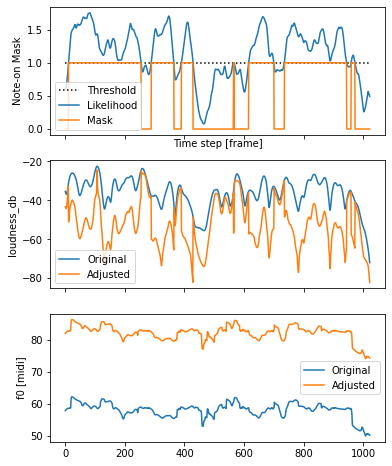

In [53]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true). 


#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 1 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 20 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 0 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Adjust the overall loudness (dB)
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = DATASET_STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=DATASET_STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)
    
    audio_features_mod['loudness_db'] = loudness_norm 

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2 
fig, axes = plt.subplots(nrows=n_plots, 
                      ncols=1, 
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])

Prediction took 4.6 seconds
Original


Resynthesis


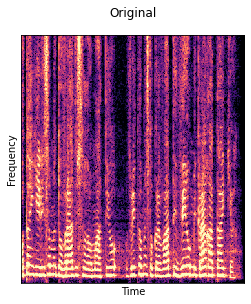

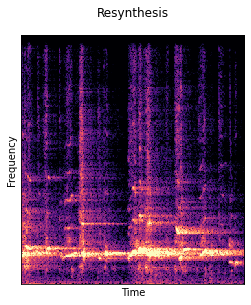

In [54]:
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
print('Prediction took %.1f seconds' % (time.time() - start_time))

# Plot
print('Original')
play(audio)

print('Resynthesis')
play(audio_gen)

specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")

In [55]:
def get_input_paths():
  data_temp = []
  for file in os.scandir("drive/MyDrive/GMMGroup/InputSounds"):
    data_temp.append([file.path, file.name])

  return pd.DataFrame(data_temp, columns=["relative_path", "filename"])

In [56]:
df = get_input_paths()
df

,relative_path,filename
0,drive/MyDrive/GMMGroup/InputSounds/f01 (2).wav,f01 (2).wav
1,drive/MyDrive/GMMGroup/InputSounds/h01 (2).wav,h01 (2).wav
2,drive/MyDrive/GMMGroup/InputSounds/d01 (2).wav,d01 (2).wav
3,drive/MyDrive/GMMGroup/InputSounds/a01 (2).wav,a01 (2).wav
4,drive/MyDrive/GMMGroup/InputSounds/s01 (2).wav,s01 (2).wav


Original


Resynthesis


Original


Resynthesis


Original


Resynthesis


Original


Resynthesis


Original


Resynthesis


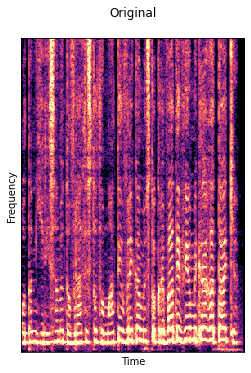

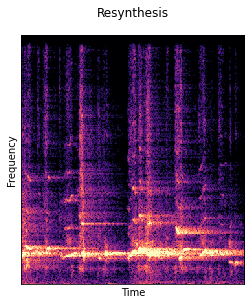

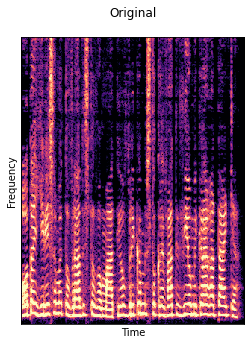

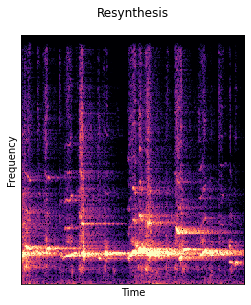

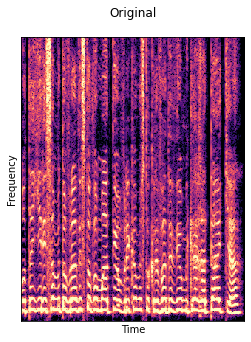

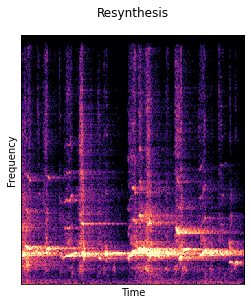

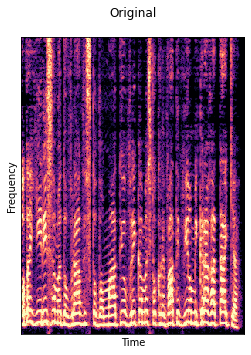

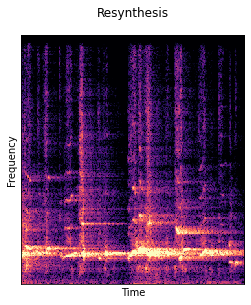

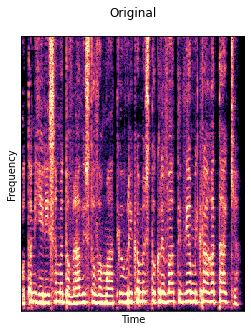

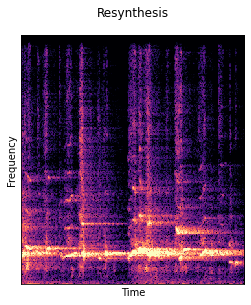

In [57]:
for path in df["relative_path"]:
  audio = read_wav_to_array(path)
  audio_features, audio_features_mod = get_audio_features(audio)
  audio_features = trim_input(audio_features, time_steps, n_samples)
  outputs = model(af, training=False)
  audio_gen = model.get_audio_from_outputs(outputs)
  print('Original')
  play(audio)

  print('Resynthesis')
  play(audio_gen)

  specplot(audio)
  plt.title("Original")

  specplot(audio_gen)
  _ = plt.title("Resynthesis")